1) Load and Preprocess Data

In [2]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

iris_df = pd.read_csv("iris.csv", names=["sepal_length", "sepal_width",
                                         "petal_length", "petal_width", "class"])
with pd.option_context('future.no_silent_downcasting', True):
    iris_df = (
        iris_df.replace({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
               .infer_objects()
    )

spam_df = pd.read_csv("spambase.csv")

iris_X = iris_df.drop("class", axis=1).values
iris_y = iris_df["class"].values

spam_X = spam_df.drop("1", axis=1).values
spam_y = spam_df["1"].values

2) Define Node and DecisionTree Classes

In [3]:
class Node:
    def __init__(self, left=None, right=None, feature=None, threshold=None, class_label=None):
        self.left = left
        self.right = right
        self.feature = feature
        self.threshold = threshold
        self.class_label = class_label

    def is_leaf(self):
        return self.class_label is not None

class DecisionTree:
    def __init__(self, n_min):
        self.root = None
        self.n_min = n_min

    def _calcEntropy(self, col):
        values, counts = np.unique(col, return_counts=True)
        prob = counts / len(col)

        entropy = 0
        for p in prob:
            if p > 0:
                entropy += p * math.log(p, 2)
        return -entropy

    def _informationGain(self, y, left_idx, right_idx):
        n = len(y)
        original_entropy = self._calcEntropy(y)
        left_entropy = self._calcEntropy(y[left_idx]) if len(left_idx) > 0 else 0
        right_entropy = self._calcEntropy(y[right_idx]) if len(right_idx) > 0 else 0
        ig = original_entropy - (
            (len(left_idx) / n) * left_entropy + (len(right_idx) / n) * right_entropy
        )
        return ig

    def _split(self, X, threshold):
        left = np.argwhere(X <= threshold).flatten()
        right = np.argwhere(X > threshold).flatten()
        return left, right

    def _find_best_split(self, X, y):
        max_ig = -1
        split_feat = None
        split_thresh = None
        for feature in range(X.shape[1]):
            col = X[:, feature]
            thresholds = np.unique(col)

            for t in thresholds:
                left, right = self._split(col, t)
                if left.shape[0] == 0 or right.shape[0] == 0:
                    continue
                ig = self._informationGain(y, left, right)
                if ig > max_ig:
                    max_ig = ig
                    split_feat = feature
                    split_thresh = t

        return split_feat, split_thresh

    def _dominantClass(self, y):
        classes, counts = np.unique(y, return_counts=True)
        return classes[np.argmax(counts)]

    def _buildTree(self, X, y):
        num_samples = X.shape[0]
        classes = np.unique(y)

        # Base cases
        if len(classes) == 1 or num_samples < self.n_min:
            leaf_class = self._dominantClass(y)
            return Node(class_label=leaf_class)

        split_feature, split_threshold = self._find_best_split(X, y)
        if split_feature is None:
            return Node(class_label=self._dominantClass(y))

        left, right = self._split(X[:, split_feature], split_threshold)

        leftSubTree = self._buildTree(X[left, :], y[left])
        rightSubTree = self._buildTree(X[right, :], y[right])

        return Node(left=leftSubTree,
                    right=rightSubTree,
                    feature=split_feature,
                    threshold=split_threshold)

    def fit(self, X, y):
        self.root = self._buildTree(X, y)

    def _traverse(self, data, node):
        if node.is_leaf():
            return node.class_label
        if data[node.feature] <= node.threshold:
            return self._traverse(data, node.left)
        else:
            return self._traverse(data, node.right)

    def predict(self, X):
        predictions = []
        for data in X:
            predictions.append(self._traverse(data, self.root))
        return np.array(predictions)

3) Plotting the Decision Tree

In [4]:
def plot_tree(node):
    """
    Plot the tree structure using matplotlib using simple recursive layout approach.
    """

    # 1) Determine the maximum depth of the tree
    max_depth = get_depth(node)
    fig, ax = plt.subplots(figsize=(12, max_depth * 1.5))
    ax.set_title("Decision Tree")
    ax.set_axis_off()

    # Start the recursive drawing
    _plot_node(ax, node, x=0, y=0, dx=80, dy=50, depth=0, max_depth=max_depth)
    plt.show()


def get_depth(node):
    """
    Returns the maximum depth of a tree.
    """
    if node is None or node.is_leaf():
        return 1
    return 1 + max(get_depth(node.left), get_depth(node.right))

def _plot_node(ax, node, x, y, dx, dy, depth, max_depth):
    """
    Recursively draw each node.
    """
    if node is None:
        return

    # Show the node label
    if node.is_leaf():
        text = f"Leaf: {node.class_label}"
    else:
        text = f"X[{node.feature}] <= {node.threshold:.2f}"

    ax.text(
        x, -y, text, ha="center", va="center",
        bbox=dict(boxstyle="round", facecolor="lightblue", edgecolor="black")
    )

    # If not leaf, draw child subtrees
    if not node.is_leaf():
        # Horizontal shifts for left and right children
        shift = dx / (2 ** depth)

        # Left child
        if node.left:
            ax.plot([x, x - shift], [-y, -(y + dy)], "k-")
            _plot_node(ax, node.left, x - shift, y + dy, dx, dy, depth + 1, max_depth)
        # Right child
        if node.right:
            ax.plot([x, x + shift], [-y, -(y + dy)], "k-")
            _plot_node(ax, node.right, x + shift, y + dy, dx, dy, depth + 1, max_depth)

4) Evaluation Function (K-Fold)

In [5]:
def eval(n_mins, X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=None)
    records = []

    for n_min in n_mins:
        # n_min is a fraction, so multiply by total samples in X
        n_min_num = int(n_min * X.shape[0])
        accuracies = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            tree = DecisionTree(n_min=n_min_num)
            tree.fit(X_train, y_train)

            y_pred = tree.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)

        records.append({
            "n_min": n_min,
            "mean_accuracy": np.mean(accuracies),
            "std_accuracy": np.std(accuracies)
        })

    df_results = pd.DataFrame(records)
    return df_results

5) Run Evaluations for Iris and Spam

In [6]:
# Evaluate on the Iris dataset
n_min_list_iris = [0.05, 0.10, 0.15, 0.20]
iris_results = eval(n_min_list_iris, iris_X, iris_y)
print("Iris Dataset Evaluation:")
print(iris_results)

# Evaluate on the Spam dataset
n_min_list_spam = [0.05, 0.10, 0.15, 0.20, 0.25]
spam_results = eval(n_min_list_spam, spam_X, spam_y)
print("\nSpam Dataset Evaluation:")
print(spam_results)

Iris Dataset Evaluation:
   n_min  mean_accuracy  std_accuracy
0   0.05       0.940000      0.062893
1   0.10       0.953333      0.084591
2   0.15       0.946667      0.058119
3   0.20       0.933333      0.051640

Spam Dataset Evaluation:
   n_min  mean_accuracy  std_accuracy
0   0.05       0.910217      0.009428
1   0.10       0.893913      0.021295
2   0.15       0.861522      0.017119
3   0.20       0.840870      0.021472
4   0.25       0.834348      0.019219


6) Example: Train a Single Tree on Iris, Plot It

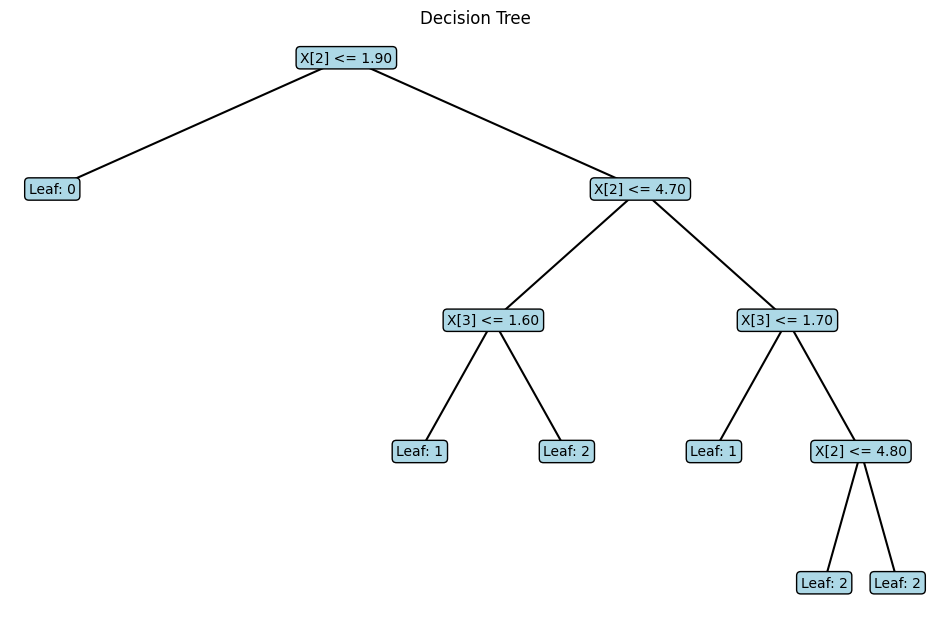

In [7]:
# For demonstration, pick a single n_min (like 0.1) and train once:
demo_n_min = 0.1
demo_n_min_num = int(demo_n_min * iris_X.shape[0])

X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(
    iris_X, iris_y, test_size=0.2, random_state=42
)

tree_demo = DecisionTree(n_min=demo_n_min_num)
tree_demo.fit(X_train_demo, y_train_demo)

# Plot that single decision tree
plot_tree(tree_demo.root)

7) Plot Accuracy vs. n_min for Iris and Spam

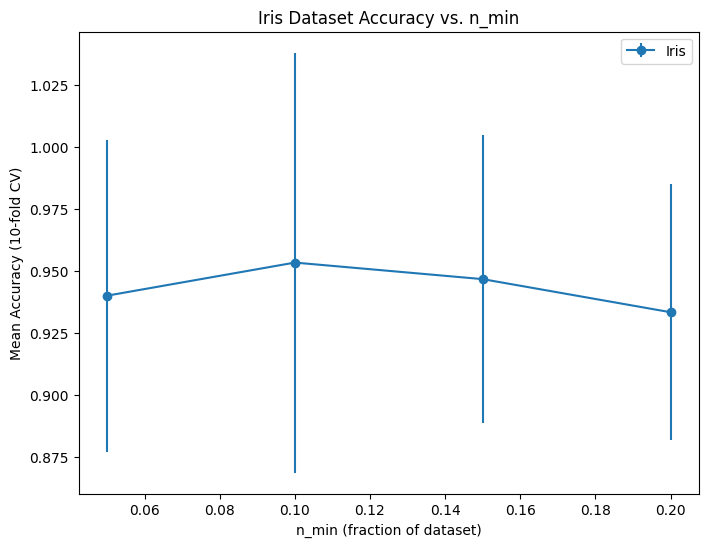

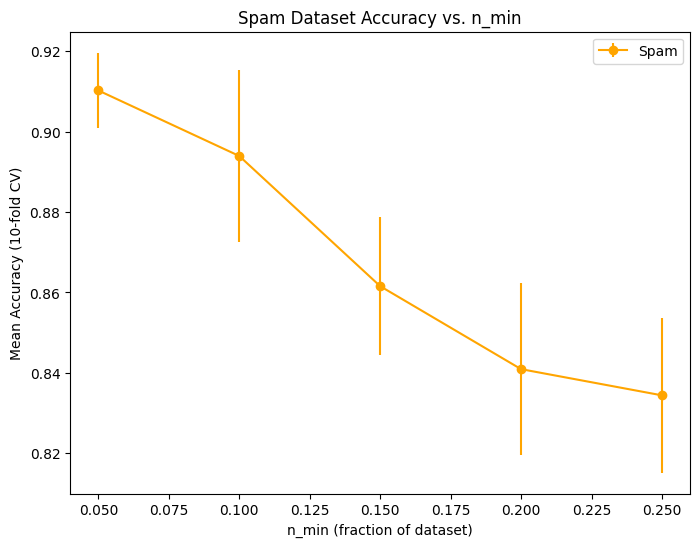

In [8]:
plt.figure(figsize=(8,6))
plt.errorbar(iris_results["n_min"], iris_results["mean_accuracy"],
             yerr=iris_results["std_accuracy"], fmt='-o', label="Iris")
plt.xlabel("n_min (fraction of dataset)")
plt.ylabel("Mean Accuracy (10-fold CV)")
plt.title("Iris Dataset Accuracy vs. n_min")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.errorbar(spam_results["n_min"], spam_results["mean_accuracy"],
             yerr=spam_results["std_accuracy"], fmt='-o', color="orange", label="Spam")
plt.xlabel("n_min (fraction of dataset)")
plt.ylabel("Mean Accuracy (10-fold CV)")
plt.title("Spam Dataset Accuracy vs. n_min")
plt.legend()
plt.show()